In [27]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import pathlib 
import numpy as np
import scipy.io as sio 

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0
Eager execution: True


In [3]:
data_root = './cars_train'
data_root = pathlib.Path(data_root)

all_image_paths = sorted([str(path) for path in data_root.iterdir()])

len(all_image_paths)

8144

In [46]:
all_image_paths

array([['cars_train/00001.jpg', '39', '116', '569', '375'],
       ['cars_train/00002.jpg', '36', '116', '868', '587'],
       ['cars_train/00003.jpg', '85', '109', '601', '381'],
       ...,
       ['cars_train/08142.jpg', '26', '246', '660', '449'],
       ['cars_train/08143.jpg', '78', '526', '1489', '908'],
       ['cars_train/08144.jpg', '20', '240', '862', '677']], dtype='<U20')

In [4]:
traindata = pd.read_csv('traindata.csv', index_col=0)

In [66]:
traindata['class'][0]

14

In [5]:
# train_paths = all_image_paths
train_labels = traindata['class'].tolist()

train_bbox = traindata[['bbox1', 'bbox2', 'bbox3', 'bbox4']].values.tolist()
train_bbox = np.array(train_bbox, dtype=np.str)

all_image_paths = np.array(all_image_paths).reshape((-1, 1))

all_image_paths = np.concatenate((all_image_paths, train_bbox), axis=1)

In [6]:
def preprocess_image(image, bbox):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.crop_to_bounding_box(image, bbox[1], bbox[0], bbox[3]-bbox[1],
                                          bbox[2] - bbox[0])
    image = tf.image.resize_images(image, [224, 224])
#     image = (image - 127.5)/127.5  # normalize to [-1,1] range
    image = tf.image.per_image_standardization(image)
#     print(image.math.maximum)
    return image

In [7]:
def load_and_preprocess_image(path):
    image = tf.read_file(path[0])
    return preprocess_image(image, tf.string_to_number(path[1:], out_type=tf.int32))

In [8]:
class_dir = "./cars_meta.mat"
def getclass(class_dir):
    annos = sio.loadmat(class_dir)
    _, num_class = annos['class_names'].shape
    class_label = {i:annos['class_names'][0,i][0] for i in range(num_class)}
    return class_label
class_label = getclass(class_dir)

In [9]:
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return str(image_rel)
caption_image(all_image_paths[0][0])

'00001.jpg'

# Build the Dataset

In [10]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image)

label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(np.array(train_labels) - 1, tf.int64))

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [19]:
image_label_ds

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


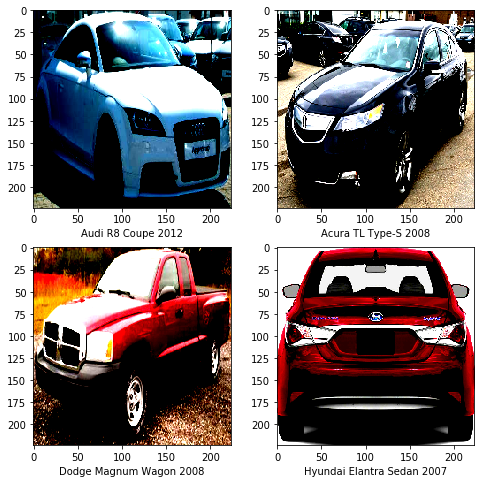

In [16]:
plt.figure(figsize=(8,8))
for n,image in enumerate(image_label_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image[0])
  plt.xlabel(class_label[traindata['class'][n]])

In [12]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<ZipDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [13]:
BATCH_SIZE = 32
image_count = len(all_image_paths)
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=64)
ds

<PrefetchDataset shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int64)>

In [ ]:
ds

### BASELINE

In [25]:
model_path = './ece228_project'
batch_size = 32
tf.enable_eager_execution

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,[5,5], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Conv2D(64,[5,5], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(196)
])
optimizer = tf.train.AdamOptimizer()

In [26]:
# def cnn_model_fn(features, labels, batch_size):
#   """Model function for CNN."""
# Input Layer
image_holder = tf.placeholder(tf.float32, [batch_size, 224, 224, 3])
label_holder = tf.placeholder(tf.int32, [batch_size])
dropout_placeholdr = tf.placeholder(tf.float32)

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
  inputs=image_holder,
  filters=32,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Dense Layer
pool2_flat = tf.reshape(pool2, [-1, 54 * 54 * 64])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(dense,dropout_placeholder)

# Logits Layer
logits = tf.layers.dense(inputs=dropout, units=196)

predictions = {
  # Generate predictions (for PREDICT and EVAL mode)
  "classes": tf.argmax(input=logits, axis=1),
  # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
  # `logging_hook`.
  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
}

#     if mode == tf.estimator.ModeKeys.PREDICT:
#     return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

# Calculate Loss (for both TRAIN and EVAL modes)
loss = tf.losses.sparse_softmax_cross_entropy(labels=tf.one_hot(labels_placeholder, 196), logits=logits)
mean_loss = tf.reduce_mean(loss)
# Configure the Training Op (for TRAIN mode)
#     if mode == tf.estimator.ModeKeys.TRAIN:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
saver = tf.train.Saver()
#     train_op = optimizer.minimize(
#         loss=loss,
#         global_step=tf.train.get_global_step())
#     return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

# Add evaluation metrics (for EVAL mode)
#     eval_metric_ops = {
#       "accuracy": tf.metrics.accuracy(
#           labels=labels, predictions=predictions["classes"])}
#     return tf.estimator.EstimatorSpec(
#       mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
with tf.Session() as sess:

    if train:
        print("训练模式")
        # 如果是训练，初始化参数
        sess.run(tf.global_variables_initializer())
        # 定义输入和Label以填充容器，训练时dropout为0.25
        train_feed_dict = {
            datas_placeholder: image_ds,
            labels_placeholder: label_ds,
            dropout_placeholdr: 0.25
        }
        for step in range(150):
            _, mean_loss_val = sess.run([optimizer, mean_loss], feed_dict=train_feed_dict)

            if step % 10 == 0:
                print("step = {}\tmean loss = {}".format(step, mean_loss_val))
        saver.save(sess, model_path)
        print("训练结束，保存模型到{}".format(model_path))
    else:
        print("测试模式")
        # 如果是测试，载入参数
        saver.restore(sess, model_path)
        print("从{}载入模型".format(model_path))
        # label和名称的对照关系
        label_name_dict = class_label
        # 定义输入和Label以填充容器，测试时dropout为0
        test_feed_dict = {
            datas_placeholder: datas,
            labels_placeholder: labels,
            dropout_placeholdr: 0
        }
        predicted_labels_val = sess.run(predicted_labels, feed_dict=test_feed_dict)
        # 真实label与模型预测label
        for fpath, real_label, predicted_label in zip(fpaths, labels, predicted_labels_val):
            # 将label id转换为label名
            real_label_name = label_name_dict[real_label]
            predicted_label_name = label_name_dict[predicted_label]
            print("{}\t{} => {}".format(fpath, real_label_name, predicted_label_name))

# Pass Dataset to model

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=True

In [ ]:
model = tf.keras.Sequential([mobile_net,tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(196, activation='softmax')])

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
# # Test Dataset Performace
# import time
# steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
# steps_per_epoch


# default_timeit_steps = 2*steps_per_epoch+1

# def timeit(ds, steps=default_timeit_steps):
#     overall_start = time.time()
#     # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
#     # before starting the timer
#     it = iter(ds.take(steps+1))
#     next(it)

#     start = time.time()
#     for i,(images,labels) in enumerate(it):
#         if i%10 == 0:
#             print('.',end='')
#     print()
#     end = time.time()

#     duration = end-start
#     print("{} batches: {} s".format(steps, duration))
#     print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
#     print("Total time: {}s".format(end-overall_start))

In [ ]:
# timeit(ds)

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [ ]:
batch_stats = CollectBatchStats()
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy().astype(np.int)
model.fit(ds, epochs=8, steps_per_epoch=steps_per_epoch, callbacks = [batch_stats])

In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,10])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)



In [ ]:
model.save_weights("model.h5")

# TestSet

In [ ]:
model2 = tf.keras.Sequential([mobile_net,tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(196, activation='softmax')])

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
model2.load_weights('./model.h5')

In [ ]:
testdata = pd.read_csv('testdata.csv', index_col=0)

In [ ]:
test_data_root = './cars_test'
test_data_root = pathlib.Path(test_data_root)

test_paths = sorted([str(path) for path in test_data_root.iterdir()])

len(test_paths)

In [ ]:
test_labels = testdata['class'].tolist()

test_bbox = testdata[['bbox1', 'bbox2', 'bbox3', 'bbox4']].values.tolist()
test_bbox = np.array(test_bbox, dtype=np.str)

test_paths = np.array(test_paths).reshape((-1, 1))

test_paths = np.concatenate((test_paths, test_bbox), axis=1)

In [ ]:
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_image)

In [ ]:
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(np.array(test_labels) - 1, tf.int64))

test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))
test_image_label_ds = test_image_label_ds.batch(BATCH_SIZE)

In [ ]:
model2.evaluate(test_image_label_ds, steps=tf.ceil(len(test_paths)/BATCH_SIZE).numpy().astype(np.int))